# M2 Hardpoint Correction Comparison between Level 3 and Telescope Mount Assembly (TMA)

This notebook is to compare the M2 hardpoint correction between the level 3 and TMA.
The coordinate system of elevation angle will be checked here as well.

## Summary

1. The expected coordinate system of elevation angle in M2 is the same as the real one in TMA with an offset value of 0.63 degree.
2. The hardpoint correction and look-up table (LUT) calculation are consistent between the level 3 and TMA.

## Import Modules

In [1]:
%matplotlib inline
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing
from astropy.time import Time
from pandas.core.frame import DataFrame
from matplotlib.axes import SubplotBase

from lsst.ts.aos.utils import DiagnosticsM2, DiagnosticsMTMount, EfdName

## Declaration of User-Defined Functions

In [2]:
def plot_elevation_angle(
    data_m2_tma: DataFrame,
    time_operation: numpy.typing.NDArray[np.float64]
) -> None:
    """Plot the elevation angle.

    Parameters
    ----------
    data_m2_tma : `pandas.core.frame.DataFrame`
        Data of M2 and TMA.
    time_operation : `numpy.ndarray`
        Operation time in second.
    """

    plt.figure()
    plt.plot(time_operation, data_m2_tma.inclinometerProcessed, "b")
    plt.plot(time_operation, data_m2_tma.actualPosition, "r-")

    plt.xlabel("Time (sec)")
    plt.ylabel("Elevation (deg)")

    plt.legend(["M2 processed inclinometer", "TMA elevation"])

    plt.title("Elevation Angle")

    plt.show()

In [3]:
async def get_data_force_moment_fbs(
    diagnostics_m2: DiagnosticsM2,
    time_start: Time,
    time_end: Time,
) -> tuple[DataFrame, DataFrame]:
    """Get the data of the net force, moment, and force balance system (FBS).

    Parameters
    ----------
    diagnostics_m2 : `lsst.ts.aos.utils.DiagnosticsM2`
        M2 diagnostics instance.
    time_start : `astropy.time.core.Time`
        Start time.
    time_end : `astropy.time.core.Time`
        End time.

    Returns
    -------
    merged_net_force_moment : `pandas.core.frame.DataFrame`
        Merged data of net force and moment.
    merged_force_balance : `pandas.core.frame.DataFrame`
        Merged data of FBS.
    """

    # Query the data
    data_zenith, _ = await diagnostics_m2.get_data_zenith_angle(
        time_start, time_end
    )
    data_net_force, _ = await diagnostics_m2.get_data_net_force(
        time_start, time_end
    )
    data_net_moment, _ = await diagnostics_m2.get_data_net_moment(
        time_start, time_end
    )
    data_force_balance, _ = await diagnostics_m2.get_data_force_balance(
        time_start, time_end
    )

    # Merge the data
    merged_net_force_moment = diagnostics_m2.rendezvous_dataframes(
        data_zenith, [data_net_force, data_net_moment]
    )
    merged_force_balance = diagnostics_m2.rendezvous_dataframes(
        data_zenith, [data_force_balance]
    )

    return merged_net_force_moment, merged_force_balance

In [4]:
def plot_comparison_force_moment(
    data_level3: DataFrame, data_tma: DataFrame, title: str
) -> None:
    """
    Plot the comparision of force and moment with different elevation angle.

    Parameters
    -------
    data_level3 : `pandas.core.frame.DataFrame`
        Force balance data at the level 3.
    data_tma : `pandas.core.frame.DataFrame`
        Force balance data at the telescope mount assembly (TMA).
    title : `str`
        Title.
    """

    fig, axs = plt.subplots(2, 3)

    components = ["fx", "fy", "fz", "mx", "my", "mz"]
    for idx, component in enumerate(components):
        row = 0 if idx < 3 else 1
        col = idx % 3
        subplot(
            axs[row, col],
            [data_level3, data_tma],
            ["b", "r"],
            component,
            "inclinometerProcessed",
        )

    axs[0, 0].set_ylabel("Force (N)")
    axs[1, 0].set_ylabel("Moment (N * m)")
    axs[1, 1].set_xlabel("Elevation (deg)")

    fig.suptitle(title)
    fig.tight_layout()
    fig.legend(["Level 3", "TMA"], loc="lower right")

    plt.show()

In [5]:
def subplot(
    ax: SubplotBase,
    datas: list[DataFrame],
    colors: list[str],
    component: str,
    axis_x: str,
) -> None:
    """Subplot.

    Parameters
    ----------
    ax : `SubplotBase`
        Subplot axes.
    datas : `list`
        Datas.
    colors : `list`
        Colors.
    component : `str`
        Componenet.
    axis_x : `str`
        X axis.
    """
    for data, color in zip(datas, colors):
        ax.plot(getattr(data, axis_x), getattr(data, component), color)

    ax.set_title(f"{component}")

## Instantiate the Diagnostics Classes

In [6]:
# USDF for the data at TMA rebalancing
diagnostics_m2 = DiagnosticsM2(efd_name=EfdName.Usdf)
diagnostics_mtmount = DiagnosticsMTMount(efd_name=EfdName.Usdf)

# IDF for the data at level 3
# To query the data at May, 2023, we need to use the IDF EFD before the data
# in USDF is recovered.
diagnostics_m2_idf = DiagnosticsM2(efd_name=EfdName.Idf)

## Check the Coordinate System of Elevation Angle

The M2 processed inclinometer value has the same coordinate system as the TMA with an offset of 0.63 degree (standard deviation is 0.13 degree) in the slewing process.
The velocity of TMA elevation movement is 0.5 deg/sec, and the offset is around 1.26 seconds.
Therefore, this offset might be real instead of the internet delay.
It is noted that we will need to calculate the internet delay before deciding the real offset value.

In addition, we might need to check this offset depends on the elevation velocity or not.
In the M2 control system, if the TMA elevation differs the internal value by >=2 degree, the system will transition to the **Fault** state to protect itself.

In [7]:
time_start_tma = Time("2023-11-16T02:00:22", scale="utc", format="isot")
time_end_tma = Time("2023-11-16T02:03:12", scale="utc", format="isot")

The elevation difference between M2 and TMA has: mean = 0.63 degree and standard deviation = 0.13 degree.


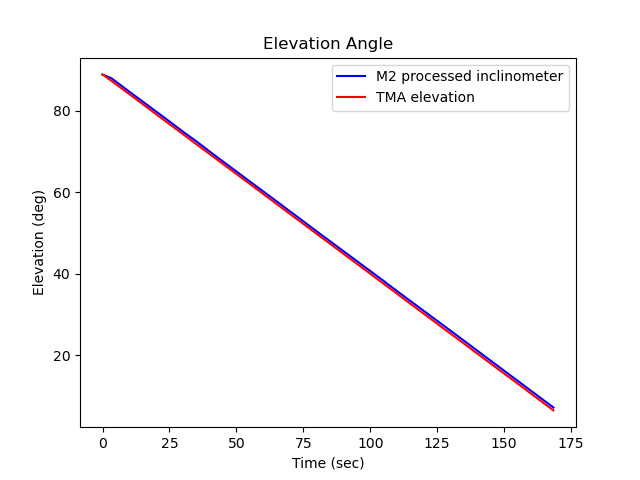

In [8]:
# Query and merge the data based on the timestamp
data_elevation_tma, _ = await diagnostics_mtmount.get_data_elevation(
    time_start_tma, time_end_tma, realign_time=True
)

data_elevation_m2, time_elevation_m2 = await diagnostics_m2.get_data_zenith_angle(
    time_start_tma, time_end_tma
)

merged_data = diagnostics_m2.rendezvous_dataframes(
    data_elevation_m2, [data_elevation_tma]
)

# Calculate the offset
difference_elevation = merged_data.inclinometerProcessed - merged_data.actualPosition
print("The elevation difference between M2 and TMA has: "
      f"mean = {np.mean(difference_elevation):.2f} degree "
      f"and standard deviation = {np.std(difference_elevation):.2f} degree."
)

# Plot the figure
plot_elevation_angle(merged_data, time_elevation_m2)

## Compare the Hardpoint Correction

Compare the hardpoint correction between the level 3 and TMA (with the **surrogate handling** look-up table).
The data of force balance system (FBS) is based on the hardpoint correction and can be used as an index to check the overall performance.
The data of TMA comes from the TMA rebalancing process, and therefore, the FBS might not be performed at the best condition.
However, this comparsion can be used to have an idea of the FBS under possible bad conditions.
It is noted that the data at level 3 has the speed of ~0.04 deg/sec and it is 0.5 deg/sec at TMA.

For the net force and moment, there is no significant difference between the level 3 and TMA.
However, there is the significant difference for $f_{y}$ and $f_{z}$ in the hardpoint correction, and this results in the difference of moments.
This implies the measured force for the actuator has the difference between the level 3 and TMA (see the **MockControlClosedLoop._calc_look_up_forces_hardpoint()** in [ts_m2com](https://github.com/lsst-ts/ts_m2com).
Actually, the main contributors of this difference are the hardpoints.
You can run the **m2_analysis_cart_rotation.ipynb** in [ts_notebooks](https://github.com/lsst-ts/ts_notebooks.git) to see this.

In [9]:
time_start_level3 = Time("2023-05-17T15:38:00", scale="utc", format="isot")
time_end_level3 = Time("2023-05-17T16:18:00", scale="utc", format="isot")

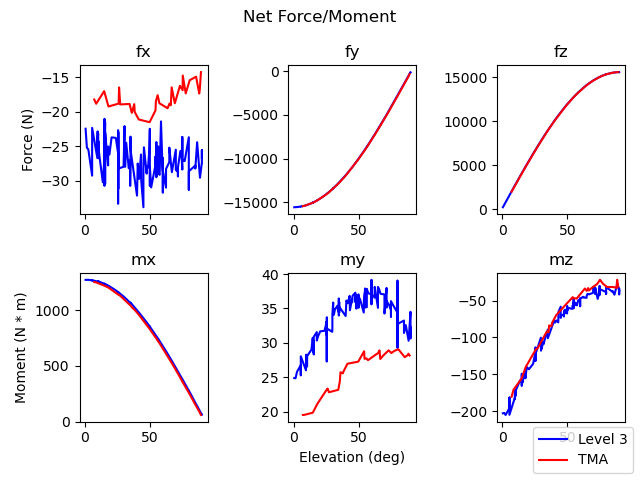

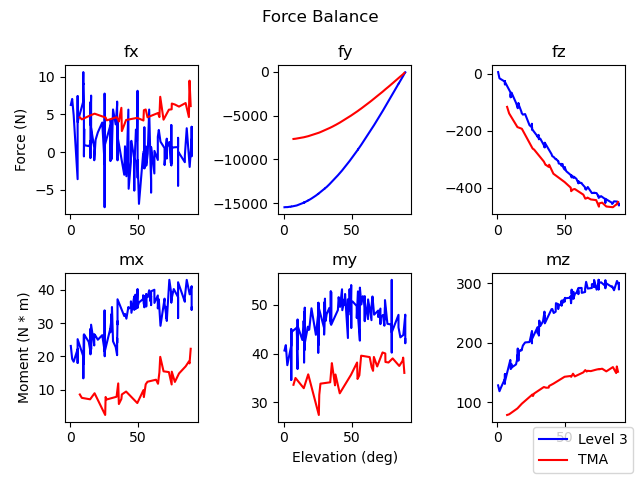

In [10]:
# Query and merge the data based on the timestamp

# Level 3
merged_net_force_moment_level3, merged_force_balance_level3 = await get_data_force_moment_fbs(
    diagnostics_m2_idf, time_start_level3, time_end_level3
)

# TMA
merged_net_force_moment_tma, merged_force_balance_tma = await get_data_force_moment_fbs(
    diagnostics_m2, time_start_tma, time_end_tma
)

# Plot the figures
plot_comparison_force_moment(
    merged_net_force_moment_level3,
    merged_net_force_moment_tma,
    "Net Force/Moment",
)
plot_comparison_force_moment(
    merged_force_balance_level3,
    merged_force_balance_tma,
    "Force Balance"
)

In [ ]:
plt.close("all")